In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import rdkit
from rdkit import DataStructs
import rdkit.Chem.AllChem as chem

import olympus
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.scalarizers import Scalarizer
from olympus.plotter import Plotter

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set



In [2]:
# helper functions


def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)
    

def get_traces(campaigns, scalarizer, return_n_best_params=10):
    traces = []
    best_n_params = []
    for campaign in campaigns:
#         print(campaign.observations.get_values().shape)
        values = campaign.observations.get_values()
        params = campaign.observations.get_params()
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
        
        sort_idx = np.argsort(scalarized)
        best_n_params.append(list(params[sort_idx][:return_n_best_params]))
        
        
    return np.array(traces), best_n_params


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)
    


def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True, linewidth=4):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=linewidth+1, zorder=11)
    ax.plot(x, mean, color=color, linewidth=linewidth, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

## `redoxmers` example

In [5]:
dataset = 'redoxmers'
case_study = 'case_study_3'

# load results

data_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/RandomSearch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gpyopt/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
    
        
data_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Botorch/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
        
data_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    with open(f'{case_study}/Gryffin/{dataset}/{sub}/results.pkl', 'rb') as content:
        data_gryffin_ = pickle.load(content)
        data_gryffin[sub] = data_gryffin_
        
        
# data_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego']:
#     with open(f'{case_study}/Hebo/{sub}/results.pkl', 'rb') as content:
#         data_hebo_ = pickle.load(content)
#         data_hebo[sub] = data_hebo_

data_gryffin['Chimera']

[<Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>,
 <Campaign (dataset=redoxmers, model=n/a, planner=Gryffin, num_iter=200)>]

In [6]:
scalarizers = {'Chimera' : Scalarizer(
                            kind='Chimera', 
                            value_space=Dataset(kind='redoxmers').value_space,
                            goals=['min', 'min', 'min'],
                            tolerances=[25., 2.04, 0.0],
                            absolutes=[True, True, False]
                        ),
               'WeightedSum':
                    Scalarizer(
                        kind='WeightedSum', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        weights=[3., 2., 1.],
                    ),
                'Parego':
                   Scalarizer(
                        kind='Parego', 
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                        rho=0.05,
                    ),
                'Hypervolume':
                    Scalarizer(
                        kind='Hypervolume',
                        value_space=Dataset(kind='redoxmers').value_space,
                        goals=['min', 'min', 'min'],
                    )
              }


# get traces
traces_random = {}
best_n_params = {}
best_n_params_df = []
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_random[sub], best_n_params[sub] = get_traces(data_random[sub], scalarizers[sub])
    
traces_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gpyopt[sub], best_n_params[sub] = get_traces(data_gpyopt[sub], scalarizers[sub])

traces_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_botorch[sub], best_n_params[sub] = get_traces(data_botorch[sub], scalarizers[sub])
    
traces_gryffin = {}
for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
    traces_gryffin[sub], best_n_params[sub] = get_traces(data_gryffin[sub], scalarizers[sub])
    
# traces_hebo = {}
# for sub in ['Chimera', 'WeightedSum', 'Parego', 'Hypervolume']:
#     traces_hebo[sub]= get_traces(data_hebo[sub], scalarizers[sub])

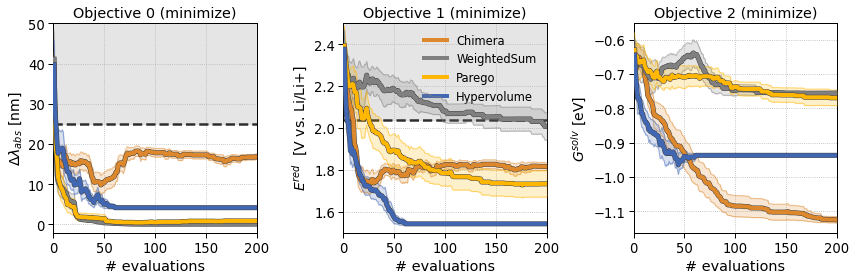

In [218]:
#---------------
# BOTORCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_botorch['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_botorch['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_botorch['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')
    plot_trace_mean(traces_botorch['Hypervolume'], obj_num=i, ax=axes[i], color='#4267B2', label='Hypervolume')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')

axes[0].set_title(f'Objective 0 (minimize)')
axes[1].set_title(f'Objective 1 (minimize)')
axes[2].set_title(f'Objective 2 (minimize)')    

#axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right', ncol=1, fontsize=11.5, frameon=False)

#axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel(r'$\Delta \lambda_{abs}$ [nm]', fontsize=14)
axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=14)
axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=14)

axes[0].axhline(25., ls='--',  c='k', lw=2.5, alpha=0.8)
axes[0].fill_between(x=[0,200], y1=25., y2=50, alpha=0.2, color='gray')
axes[0].set_xlim(0, 200)
axes[0].set_ylim(-2, 50)


axes[1].axhline(2.04, ls='--',  c='k', lw=2.5, alpha=0.8)
axes[1].fill_between(x=[0,200], y1=2.04, y2=2.5, alpha=0.2, color='gray')
axes[1].set_xlim(0, 200)
axes[1].set_ylim(1.5, 2.5)

for ax in axes:
    ax.grid(linestyle=":")
    


#axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
plt.savefig('redoxmers_botorch_traces.png', dpi=300)

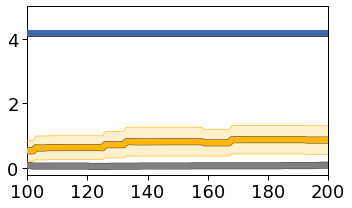

In [213]:
# zoomed in plot of first objective
# TODO: make the tick sizes bigger here

fig, ax = plt.subplots(figsize=(5, 3))

plot_trace_mean(traces_botorch['Chimera'], obj_num=0, ax=ax, color='#dd882c', label='Chimera', linewidth=6)
plot_trace_mean(traces_botorch['WeightedSum'], obj_num=0, ax=ax, color='gray', label='WeightedSum',linewidth=6)
plot_trace_mean(traces_botorch['Parego'], obj_num=0, ax=ax, color='#ffb703', label='Parego',linewidth=6)
plot_trace_mean(traces_botorch['Hypervolume'], obj_num=0, ax=ax, color='#4267B2', label='Hypervolume',linewidth=6)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

ax.set_xlim(100, 200)
ax.set_ylim(-0.2, 5)
plt.tight_layout()
plt.savefig('redoxmers_botorch_obj1_zoom_in.png', dpi=300)

In [6]:
df_orig = Dataset(kind='redoxmers').data

In [7]:
df_orig.head()

,r1_label,r3_label,r4_label,r5_label,abs_lam_diff,ered,gsol
0,R1_0,R3_0,R4_0,R5_0,39.96,1.684123,-0.681801
1,R1_0,R3_0,R4_0,R5_1,63.92,1.963624,-0.711542
2,R1_0,R3_0,R4_0,R5_2,51.76,2.044655,-0.8874
3,R1_0,R3_0,R4_0,R5_3,36.93,1.731604,-0.710235
4,R1_0,R3_0,R4_0,R5_4,53.79,1.844226,-0.748112


In [10]:
raw_df = pd.read_csv('../src/olympus/datasets/dataset_redoxmers/raw_data/df_results.csv')
# make product mols
prod_smiles = raw_df['product_smiles'].tolist()
prod_mols = [chem.MolFromSmiles(s) for s in prod_smiles]

# prod_fps = [np.array(Chem.GetMorganFingerprintAsBitVect(m, 3)) for m in prod_mols ]
prod_fps = [chem.GetMorganFingerprintAsBitVect(m, 3) for m in prod_mols ]
fps_dict = {s:fp for s, fp in zip(prod_smiles, prod_fps)}
raw_df['product_mols'] = prod_mols
print(raw_df.shape)
raw_df.head()

(1407, 2395)


,Unnamed: 0,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,...,r5_MW,r5_AMW,r5_WPath,r5_WPol,r5_Zagreb1,r5_Zagreb2,r5_mZagreb2,r5_type,r5_ix,product_mols
0,0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,16.031300,3.206260,0,0,0.0,0.0,0.0,R5,0,<rdkit.Chem.rdchem.Mol object at 0x7fd9b6776530>
1,1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,70.003035,14.000607,9,0,12.0,9.0,1.0,R5,1,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5a57300>
2,2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,27.010899,9.003633,1,0,2.0,1.0,1.0,R5,2,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5ac3b20>
3,3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,32.026215,5.337702,1,0,2.0,1.0,1.0,R5,3,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5ac3a80>
4,4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,85.997949,14.332992,16,0,20.0,16.0,1.0,R5,4,<rdkit.Chem.rdchem.Mol object at 0x7fd9b4933c10>


In [12]:
def lookup_prod_smiles_mol(r1_label, r3_label, r4_label, r5_label, raw_df):
    
    match = raw_df[
        (raw_df['r1_label']==r1_label)&
        (raw_df['r3_label']==r3_label)&
        (raw_df['r4_label']==r4_label)&
        (raw_df['r5_label']==r5_label)
    ]
    assert len(match)==1
    match = match.to_dict('r')[0]
    smi, mol = match['product_smiles'], match['product_mols']
    fp = fps_dict[smi]
    return smi, mol, fp

def get_similarity_distribution(campaigns, raw_df):
    
    smiles, mols, fps = [], [], []

    for campaign in campaigns:
        for param in campaign.observations.get_params():
            # this is dataset specific
            smi, mol, fp = lookup_prod_smiles_mol(param[0], param[1], param[2], param[3], raw_df)
            smiles.append(smi)
            mols.append(mol)
            fps.append(fp)
    # compute all fp pairwise distances without duplicates
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)-1): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(smiles[n])
            ta.append(smiles[n+1:][m])
            sim.append(s[m])

    d = {'query':qu, 'target':ta, 'similarity':sim}
    df_sim = pd.DataFrame(data=d)
    #df_sim = df_sim.sort_values('similarity', ascending=False)
    
    return df_sim




In [13]:
# df_sim_chimera = get_similarity_distribution(data_gpyopt['Chimera'][:1], raw_df)
# df_sim_weightedsum = get_similarity_distribution(data_gpyopt['WeightedSum'][:1], raw_df)
# df_sim_parego = get_similarity_distribution(data_gpyopt['Parego'][:1], raw_df)
# df_sim_hypervolume = get_similarity_distribution(data_gpyopt['Hypervolume'][:1], raw_df)

In [14]:

best_n_params

{'Chimera': [[array(['R1_0', 'R3_7', 'R4_3', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_2'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_0'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_5'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_3', 'R5_1'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_6'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_3', 'R5_3'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_3'], dtype='<U5')],
  [array(['R1_0', 'R3_7', 'R4_3', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_0', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_10'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_0'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_2', 'R5_3'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_5'], dtype='<U5'),
   array(['R1_0', 'R3_7', 'R4_7', 'R5_6'], dtype='<U5'),
   array(['R1

In [16]:
def get_pareto_data(campaigns):
    pareto_fronts, pareto_sets = [], []
    hypervolumes = []
    values_ = []
    # get the pareto optimal sets and the hypervolumes after the 200 evaluation budget
    for campaign in campaigns:

        params = campaign.observations.get_params()
        values = campaign.observations.get_values()

        pareto_front, pareto_set = get_pareto_set(params, values)
        w_ref = np.amax(df_orig[['abs_lam_diff', 'ered', 'gsol']].values, axis=0)
        #print(w_ref)
        hypervolume = get_hypervolume(values, w_ref)
        
        pareto_fronts.append(pareto_front)
        pareto_sets.append(pareto_set)
        hypervolumes.append(hypervolume)

        idxs = [ np.where(np.all(values==p, axis=1))[0][0] for p in pareto_front ] 
        assert len(idxs)==pareto_front.shape[0]
        values = np.delete(values, idxs, axis=0)
        values_.append(values)
        
    return pareto_fronts, pareto_sets, hypervolumes, values_
    

def make_plotly_df(pareto_fronts, values_):
    front_df = pd.DataFrame(
        {'abs_lam_diff': pareto_fronts[:, 0], 'ered': pareto_fronts[:, 1], 'gsol': pareto_fronts[:, 2]}
    )
    front_df['type'] = 'front'
    front_df['size'] = 10
    full_df = pd.DataFrame(
        {'abs_lam_diff': values_[:, 0], 'ered': values_[:, 1], 'gsol': values_[:, 2]}
    )
    full_df['type'] = 'normal'
    full_df['size'] = 2
    df = pd.concat((front_df, full_df))
    return df


In [18]:
pareto_fronts_hv, pareto_sets_hv, hypervolumes_hv, values_hv = get_pareto_data(data_gpyopt['Hypervolume'])
df_hv = make_plotly_df(pareto_fronts_hv[0], values_hv[0])

pareto_fronts_chi, pareto_sets_chi, hypervolumes_chi, values_chi = get_pareto_data(data_gpyopt['Chimera'])
df_chi = make_plotly_df(pareto_fronts_chi[0], values_chi[0])


pareto_fronts_ws, pareto_sets_ws, hypervolumes_ws, values_ws = get_pareto_data(data_gpyopt['WeightedSum'])
df_ws = make_plotly_df(pareto_fronts_ws[0], values_ws[0])

pareto_fronts_par, pareto_sets_par, hypervolumes_par, values_par = get_pareto_data(data_gpyopt['Parego'])
df_par = make_plotly_df(pareto_fronts_par[0], values_par[0])

#---------------------
# make pareto sets df
#---------------------

# all_pareto_sets = {'method': [], 'R1': [], 'R3': [], 'R4': [], 'R5': [], 'smiles': []}
# for method, data in zip(['Hypervolume', 'Chimera', 'ParEGO', 'Weighted Sum'], [pareto_sets_hv,pareto_sets_chi,pareto_sets_ws,pareto_sets_par]):
    
#     for array in data:
#         for instance in array:
#             all_pareto_sets['method'].append(method)
#             all_pareto_sets['R1'].append(instance[0])
#             all_pareto_sets['R3'].append(instance[1])
#             all_pareto_sets['R4'].append(instance[2])
#             all_pareto_sets['R5'].append(instance[3])
#             smiles = lookup_prod_smiles_mol(
#                 instance[0], instance[1], instance[2], instance[3], raw_df
#             )
#             all_pareto_sets['smiles'].append(smiles)
            
            
# pareto_sets_df = pd.DataFrame(all_pareto_sets)
    

# full hypervolume
values = df_orig[['abs_lam_diff', 'ered', 'gsol']].values
w_ref = np.amax(values, axis=0)
#print(w_ref)
full_hypervolume = get_hypervolume(values, w_ref)


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [19]:
pareto_sets_df.head()

,method,R1,R3,R4,R5,smiles
0,Hypervolume,R1_0,R3_7,R4_3,R5_3,"(CCOCN(C(C)=O)c1c(N(C)C)c(OC)c(OC)c2nsnc12, <r..."
1,Hypervolume,R1_0,R3_7,R4_0,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(C)c(S(=O)(=O)N(C)C)c...
2,Hypervolume,R1_0,R3_7,R4_7,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(N(C)C)c(S(=O)(=O)N(C...
3,Hypervolume,R1_0,R3_7,R4_3,R5_10,(CCOCN(C(C)=O)c1c(N(C)C)c(OC)c(S(=O)(=O)N(C)C)...
4,Hypervolume,R1_0,R3_5,R4_7,R5_10,(CCOCN(C(C)=O)c1c(SC)c(N(C)C)c(S(=O)(=O)N(C)C)...


In [22]:
# save these expensive results to disk
pickle.dump(pareto_sets_df, open('pareto_sets_params.pkl', 'wb'))

In [38]:
# get counts of all the R group options in the flattened Pareto sets
hv_sets = pareto_sets_df[pareto_sets_df['method']=='Hypervolume']
hv_counts_r1 = dict(hv_sets['R1'].value_counts())
hv_counts_r3 = dict(hv_sets['R3'].value_counts())
hv_counts_r4 = dict(hv_sets['R4'].value_counts())
hv_counts_r5 = dict(hv_sets['R5'].value_counts())
hv_smiles = [row.to_dict()['smiles'][0] for _, row in hv_sets.iterrows()]
hv_sets['smi'] = hv_smiles
hv_counts_smiles = dict(hv_sets['smi'].value_counts())

chi_sets = pareto_sets_df[pareto_sets_df['method']=='Chimera']
chi_counts_r1 = dict(chi_sets['R1'].value_counts())
chi_counts_r3 = dict(chi_sets['R3'].value_counts())
chi_counts_r4 = dict(chi_sets['R4'].value_counts())
chi_counts_r5 = dict(chi_sets['R5'].value_counts())
chi_smiles = [row.to_dict()['smiles'][0] for _, row in chi_sets.iterrows()]
chi_sets['smi'] = chi_smiles
chi_counts_smiles = dict(chi_sets['smi'].value_counts())

par_sets = pareto_sets_df[pareto_sets_df['method']=='ParEGO']
par_counts_r1 = dict(par_sets['R1'].value_counts())
par_counts_r3 = dict(par_sets['R3'].value_counts())
par_counts_r4 = dict(par_sets['R4'].value_counts())
par_counts_r5 = dict(par_sets['R5'].value_counts())
par_smiles = [row.to_dict()['smiles'][0] for _, row in par_sets.iterrows()]
par_sets['smi'] = par_smiles
par_counts_smiles = dict(par_sets['smi'].value_counts())

ws_sets = pareto_sets_df[pareto_sets_df['method']=='Weighted Sum']
ws_counts_r1 = dict(ws_sets['R1'].value_counts())
ws_counts_r3 = dict(ws_sets['R3'].value_counts())
ws_counts_r4 = dict(ws_sets['R4'].value_counts())
ws_counts_r5 = dict(ws_sets['R5'].value_counts())
ws_smiles = [row.to_dict()['smiles'][0] for _, row in ws_sets.iterrows()]
ws_sets['smi'] = ws_smiles
ws_counts_smiles = dict(ws_sets['smi'].value_counts())

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


['R1_0' 'R1_1']
2
['R3_7' 'R3_5' 'R3_0' 'R3_2' 'R3_1' 'R3_3' 'R3_6' 'R3_4']
8
dict_keys(['R3_7', 'R3_0', 'R3_5', 'R3_2', 'R3_1', 'R3_6', 'R3_3', 'R3_4'])
dict_values([289, 178, 64, 49, 32, 15, 10, 7])
dict_values([289, 178, 64, 49, 32, 15, 10, 7])
['R4_3' 'R4_0' 'R4_7' 'R4_4' 'R4_5' 'R4_6' 'R4_1']
7
--------------------------------------------------
['R5_3' 'R5_10' 'R5_0' 'R5_5' 'R5_8' 'R5_6']
6
dict_values([174, 174, 124, 39, 35, 15, 7, 7, 6, 1])
[0.3 1.3 2.3 3.3 4.3 5.3]
[174 174 124  39  35  15]


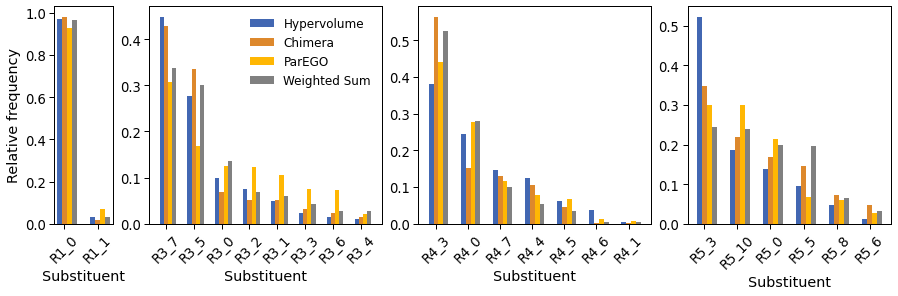

In [87]:
# make bar chart of the frequencies
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=False, gridspec_kw={'width_ratios': [0.5,2,2,1.75]} )

strategy = ['Hypervolume', 'Chimera',  'ParEGO', 'Weighted Sum']
colors = {'Hypervolume': '#4267B2', 'Chimera': '#dd882c', 'Parego': '#ffb703', 'Weighted Sum': 'gray' }
linewidth=3

#-----------
# R1 GROUPS
#-----------
n = len(hv_sets['R1'].unique()) # of R-group options
options = hv_sets['R1'].unique()
print(options)
print(n) 
ind = np.arange(n) 
width = 0.15
      
bar_hv = axes[0].bar(
    ind, 
    np.array(list(hv_counts_r1.values()))/np.sum(np.array(list(hv_counts_r1.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[0].bar(
    ind+width, 
    np.array(list(chi_counts_r1.values()))/np.sum(np.array(list(chi_counts_r1.values()))),  
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[0].bar(
    ind+width*2, 
    np.array(list(par_counts_r1.values()))/np.sum(np.array(list(par_counts_r1.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[0].bar(
    ind+width*3, 
    np.array(list(ws_counts_r1.values()))/np.sum(np.array(list(ws_counts_r1.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
axes[0].set_xlabel("Substituent")
axes[0].set_ylabel('Relative frequency')
# plt.title("Players Score")
  
axes[0].set_xticks(ind+width, options,rotation=45)

#-----------
# R2 GROUPS
#-----------
n = len(hv_sets['R3'].unique()) # of R-group options
options = hv_sets['R3'].unique()
print(options)
print(n) 
ind = np.arange(n) 
width = 0.15

print(hv_counts_r3.keys())
print(hv_counts_r3.values())
print(np.array(hv_counts_r3.values()))
      
bar_hv = axes[1].bar(
    ind, 
    np.array(list(hv_counts_r3.values()))/np.sum(np.array(list(hv_counts_r3.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[1].bar(
    ind+width, 
    np.array(list(chi_counts_r3.values()))/np.sum(np.array(list(chi_counts_r3.values()))), 
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[1].bar(
    ind+width*2, 
    np.array(list(par_counts_r3.values()))/np.sum(np.array(list(par_counts_r3.values()))),  
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[1].bar(
    ind+width*3, 
    np.array(list(ws_counts_r3.values()))/np.sum(np.array(list(ws_counts_r3.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
axes[1].set_xlabel("Substituent")
axes[1].set_xticks(ind+width, options,rotation=45)
axes[1].legend( (bar_hv, bar_chi, bar_par, bar_ws), strategy, fontsize=12, frameon=False)


#-----------
# R3 GROUPS
#-----------
n = len(hv_sets['R4'].unique()) # of R-group options
options = hv_sets['R4'].unique()
print(options)
print(n) 
ind = np.arange(n) 
width = 0.15
      
bar_hv = axes[2].bar(
    ind, 
    np.array(list(hv_counts_r4.values()))/np.sum(np.array(list(hv_counts_r4.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[2].bar(
    ind+width, 
    np.array(list(chi_counts_r4.values()))/np.sum(np.array(list(chi_counts_r4.values()))),
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[2].bar(
    ind+width*2, 
    np.array(list(par_counts_r4.values()))/np.sum(np.array(list(par_counts_r4.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[2].bar(
    ind+width*3, 
    np.array(list(ws_counts_r4.values()))/np.sum(np.array(list(ws_counts_r4.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
axes[2].set_xlabel("Substituent")
axes[2].set_xticks(ind+width, options, rotation=45)


#-----------
# R4 GROUPS
#-----------
n = len(hv_sets['R5'].unique()) # of R-group options
options = hv_sets['R5'].unique()
print('-'*50)
print(options)
print(n) 
ind = np.arange(n) 
width = 0.15

print(par_counts_r5.values())
      
bar_hv = axes[3].bar(
    ind, 
    np.array(list(hv_counts_r5.values()))/np.sum(np.array(list(hv_counts_r5.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[3].bar(
    ind+width, 
    np.array(list(chi_counts_r5.values()))/np.sum(np.array(list(chi_counts_r5.values()))), 
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)

print(ind+width*2)
print( np.array(list(par_counts_r5.values()))[:6] )
  
bar_par = axes[3].bar(
    ind+width*2, 
    np.array(list(par_counts_r5.values()))[:6]/np.sum(np.array(list(par_counts_r5.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[3].bar(
    ind+width*3, 
    np.array(list(ws_counts_r5.values()))[:6]/np.sum(np.array(list(ws_counts_r5.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
axes[3].set_xlabel("Substituent")
axes[3].set_xticks(ind+width, options, rotation=45)
plt.show()

In [92]:
# visualize structures of the best molecules according to each scalarizer
top_smiles_hv = list(hv_counts_smiles.keys())
top_mols_hv = [chem.MolFromSmiles(s) for s in top_smiles_hv]

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_hv, molsPerRow=5, returnPNG=False)
img.save('top_mols_hv.png')

In [93]:
top_smiles_chi = list(chi_counts_smiles.keys())
top_mols_chi = [chem.MolFromSmiles(s) for s in top_smiles_chi]

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_chi, molsPerRow=5, returnPNG=False)
img.save('top_mols_chi.png')

In [ ]:
top_smiles_par = list(par_counts_smiles.keys())
top_mols_par = [chem.MolFromSmiles(s) for s in top_smiles_par]

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_par, molsPerRow=5, returnPNG=False)
img.save('top_mols_par.png')

In [94]:
top_smiles_ws = list(ws_counts_smiles.keys())
top_mols_ws = [chem.MolFromSmiles(s) for s in top_smiles_ws]

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_ws, molsPerRow=5, returnPNG=False)
img.save('top_mols_ws.png')

In [117]:
# rank the dataset acording to each scalarizer

keep_cols = ['product_smiles', 'r1_label', 'r1_smiles',
       'r1_smiles_raw', 'r3_label', 'r3_smiles', 'r3_smiles_raw', 'r4_label',
       'r4_smiles', 'r4_smiles_raw', 'r5_label', 'r5_smiles', 'r5_smiles_raw',
       'abs_lam_diff', 'ered', 'gsol', 'merit', 'rank' ]

hv_df = raw_df.copy()
objs_hv = hv_df[['abs_lam_diff', 'ered', 'gsol']].values
merits_hv = scalarizers['Hypervolume'].scalarize(objs_hv)
# print(merits_hv)
hv_df['merit'] = merits_hv
hv_df = hv_df.sort_values(by='merit', ascending=True)
hv_df['rank'] = np.arange(hv_df.shape[0])+1
hv_df = hv_df[keep_cols]

chi_df = raw_df.copy()
objs_chi = chi_df[['abs_lam_diff', 'ered', 'gsol']].values
merits_chi = scalarizers['Chimera'].scalarize(objs_chi)
# print(merits_chi)
chi_df['merit'] = merits_chi
chi_df = chi_df.sort_values(by='merit', ascending=True)
chi_df['rank'] = np.arange(chi_df.shape[0])+1
chi_df = chi_df[keep_cols]

par_df = raw_df.copy()
objs_par = par_df[['abs_lam_diff', 'ered', 'gsol']].values
merits_par = scalarizers['Parego'].scalarize(objs_par)
# print(merits_chi)
par_df['merit'] = merits_par
par_df = par_df.sort_values(by='merit', ascending=True)
par_df['rank'] = np.arange(par_df.shape[0])+1
par_df = par_df[keep_cols]

ws_df = raw_df.copy()
objs_ws = ws_df[['abs_lam_diff', 'ered', 'gsol']].values
merits_ws = scalarizers['WeightedSum'].scalarize(objs_ws)
# print(merits_chi)
ws_df['merit'] = merits_ws
ws_df = ws_df.sort_values(by='merit', ascending=True)
ws_df['rank'] = np.arange(ws_df.shape[0])+1
ws_df = ws_df[keep_cols]




In [132]:

num_mols = 10
top_smiles_hv = hv_df['product_smiles'].tolist()[:num_mols]
top_mols_hv   = [chem.MolFromSmiles(s) for s in top_smiles_hv]
top_abs_lam_diff_hv = hv_df['abs_lam_diff'].tolist()[:num_mols]
top_ered_hv = hv_df['ered'].tolist()[:num_mols]
top_gsol_hv = hv_df['gsol'].tolist()[:num_mols]
legends_hv = [
    f'abs lam diff : {round(a,3)}\nered : {round(e,3)}\ngsol : {round(g,3)}' for a, e, g in zip(top_abs_lam_diff_hv,top_ered_hv,top_gsol_hv)
]
print(len(top_abs_lam_diff_hv))

top_smiles_chi = chi_df['product_smiles'].tolist()[:num_mols]
top_mols_chi   = [chem.MolFromSmiles(s) for s in top_smiles_chi]
top_abs_lam_diff_chi = chi_df['abs_lam_diff'].tolist()[:num_mols]
top_ered_chi = chi_df['ered'].tolist()[:num_mols]
top_gsol_chi = chi_df['gsol'].tolist()[:num_mols]
legends_chi = [
    f'abs lam diff : {round(a,3)}\nered : {round(e,3)}\ngsol : {round(g,3)}' for a, e, g in zip(top_abs_lam_diff_chi,top_ered_chi,top_gsol_chi)
]


top_smiles_par = par_df['product_smiles'].tolist()[:num_mols]
top_mols_par   = [chem.MolFromSmiles(s) for s in top_smiles_par]
top_abs_lam_diff_par = par_df['abs_lam_diff'].tolist()[:num_mols]
top_ered_par = par_df['ered'].tolist()[:num_mols]
top_gsol_par = par_df['gsol'].tolist()[:num_mols]
legends_par = [
    f'abs lam diff : {round(a,3)}\nered : {round(e,3)}\ngsol : {round(g,3)}' for a, e, g in zip(top_abs_lam_diff_par,top_ered_par,top_gsol_par)
]

top_smiles_ws = ws_df['product_smiles'].tolist()[:num_mols]
top_mols_ws   = [chem.MolFromSmiles(s) for s in top_smiles_ws]
top_abs_lam_diff_ws = ws_df['abs_lam_diff'].tolist()[:num_mols]
top_ered_ws = ws_df['ered'].tolist()[:num_mols]
top_gsol_ws = ws_df['gsol'].tolist()[:num_mols]
legends_ws = [
    f'abs lam diff : {round(a,3)}\nered : {round(e,3)}\ngsol : {round(g,3)}' for a, e, g in zip(top_abs_lam_diff_ws,top_ered_ws,top_gsol_ws)
]

10


In [136]:
img = rdkit.Chem.AllChem.Draw.MolsToGridImage(
    top_mols_hv, molsPerRow=5, subImgSize=(300, 300), returnPNG=False, legends=legends_hv
)
img.save('top_20_mols_hv_rank.png')

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_chi, molsPerRow=5, subImgSize=(300, 300), returnPNG=False, legends=legends_chi)
img.save('top_20_mols_chi_rank.png')

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_par, molsPerRow=5, subImgSize=(300, 300), returnPNG=False, legends=legends_par)
img.save('top_20_mols_par_rank.png')

img = rdkit.Chem.AllChem.Draw.MolsToGridImage(top_mols_ws, molsPerRow=5, subImgSize=(300, 300), returnPNG=False, legends=legends_ws)
img.save('top_20_mols_ws_rank.png')

In [170]:
def make_value_counts(sub_df, raw_df, rgroup='r1', num_mols=20):
    options = raw_df[f'{rgroup}_label'].unique().tolist()
    sub_df_counts = dict(sub_df.iloc[:num_mols,:][f'{rgroup}_label'].value_counts())
    ordered_counts = {}
    for key in options:
        if key in list(sub_df_counts.keys()):
            ordered_counts[key] = sub_df_counts[key]
        else:
            ordered_counts[key]=0
    return ordered_counts

In [173]:
num_mols = 50
hv_counts_r1 = make_value_counts(hv_df, raw_df, 'r1', num_mols)
hv_counts_r3 = make_value_counts(hv_df, raw_df, 'r3', num_mols)
hv_counts_r4 = make_value_counts(hv_df, raw_df, 'r4', num_mols)
hv_counts_r5 = make_value_counts(hv_df, raw_df, 'r5', num_mols)

chi_counts_r1 = make_value_counts(chi_df, raw_df, 'r1', num_mols)
chi_counts_r3 = make_value_counts(chi_df, raw_df, 'r3', num_mols)
chi_counts_r4 = make_value_counts(chi_df, raw_df, 'r4', num_mols)
chi_counts_r5 = make_value_counts(chi_df, raw_df, 'r5', num_mols)

par_counts_r1 = make_value_counts(par_df, raw_df, 'r1', num_mols)
par_counts_r3 = make_value_counts(par_df, raw_df, 'r3', num_mols)
par_counts_r4 = make_value_counts(par_df, raw_df, 'r4', num_mols)
par_counts_r5 = make_value_counts(par_df, raw_df, 'r5', num_mols)

ws_counts_r1 = make_value_counts(ws_df, raw_df, 'r1', num_mols)
ws_counts_r3 = make_value_counts(ws_df, raw_df, 'r3', num_mols)
ws_counts_r4 = make_value_counts(ws_df, raw_df, 'r4', num_mols)
ws_counts_r5 = make_value_counts(ws_df, raw_df, 'r5', num_mols)

['R1_0' 'R1_1']
2
['R3_0' 'R3_1' 'R3_2' 'R3_3' 'R3_4' 'R3_5' 'R3_6' 'R3_7']
8
['R3_0', 'R3_1', 'R3_2', 'R3_3', 'R3_4', 'R3_5', 'R3_6', 'R3_7']
[9, 1, 0, 7, 2, 7, 0, 24]
[ 9  1  0  7  2  7  0 24]
['R4_0' 'R4_1' 'R4_2' 'R4_3' 'R4_4' 'R4_5' 'R4_6' 'R4_7']
8
--------------------------------------------------
['R5_0' 'R5_1' 'R5_2' 'R5_3' 'R5_4' 'R5_5' 'R5_6' 'R5_7' 'R5_8' 'R5_9'
 'R5_10']
11


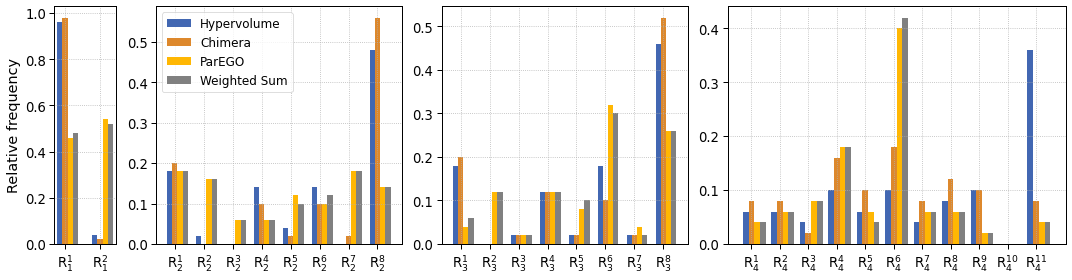

In [208]:
# make bar chart of the frequencies
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=False, gridspec_kw={'width_ratios': [2,8,8,11]} )

strategy = ['Hypervolume', 'Chimera',  'ParEGO', 'Weighted Sum']
colors = {'Hypervolume': '#4267B2', 'Chimera': '#dd882c', 'Parego': '#ffb703', 'Weighted Sum': 'gray' }
linewidth=3

#-----------
# R1 GROUPS
#-----------
n = len(raw_df['r1_label'].unique()) # of R-group options
options = raw_df['r1_label'].unique()
format_options = [r'R$_1^1$', r'R$_1^2$']
print(options)
print(n) 
ind = np.arange(n) 
width = 0.15
      
bar_hv = axes[0].bar(
    ind, 
    np.array(list(hv_counts_r1.values()))/np.sum(np.array(list(hv_counts_r1.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[0].bar(
    ind+width, 
    np.array(list(chi_counts_r1.values()))/np.sum(np.array(list(chi_counts_r1.values()))),  
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[0].bar(
    ind+width*2, 
    np.array(list(par_counts_r1.values()))/np.sum(np.array(list(par_counts_r1.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[0].bar(
    ind+width*3, 
    np.array(list(ws_counts_r1.values()))/np.sum(np.array(list(ws_counts_r1.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
# axes[0].set_xlabel("Substituent")
axes[0].set_ylabel('Relative frequency')
# plt.title("Players Score")
  
axes[0].set_xticks(ind+width, format_options,rotation=0)

print('='*50)

#-----------
# R2 GROUPS
#-----------
n = len(raw_df['r3_label'].unique()) # of R-group options
options = raw_df['r3_label'].unique()
format_options = [r'R$_2^1$', r'R$_2^2$', r'R$_2^3$', r'R$_2^4$', r'R$_2^5$', r'R$_2^6$', r'R$_2^7$', r'R$_2^8$']
print(options)
print(n) 
ind = np.arange(n) 
width = 0.18

print(list(hv_counts_r3.keys()))
print(list(hv_counts_r3.values()))
print(np.array(list(hv_counts_r3.values())))
      
bar_hv = axes[1].bar(
    ind, 
    np.array(list(hv_counts_r3.values()))/np.sum(np.array(list(hv_counts_r3.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[1].bar(
    ind+width, 
    np.array(list(chi_counts_r3.values()))/np.sum(np.array(list(chi_counts_r3.values()))), 
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[1].bar(
    ind+width*2, 
    np.array(list(par_counts_r3.values()))/np.sum(np.array(list(par_counts_r3.values()))),  
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[1].bar(
    ind+width*3, 
    np.array(list(ws_counts_r3.values()))/np.sum(np.array(list(ws_counts_r3.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
# axes[1].set_xlabel("Substituent")
axes[1].set_xticks(ind+width, format_options,rotation=0)
axes[1].legend( (bar_hv, bar_chi, bar_par, bar_ws), strategy, fontsize=12, frameon=True)


#-----------
# R3 GROUPS
#-----------
n = len(raw_df['r4_label'].unique()) # of R-group options
options = raw_df['r4_label'].unique()
format_options = [r'R$_3^1$', r'R$_3^2$', r'R$_3^3$', r'R$_3^4$', r'R$_3^5$', r'R$_3^6$', r'R$_3^7$', r'R$_3^8$']
print(options)
print(n) 
ind = np.arange(n) 
width = 0.18
      
bar_hv = axes[2].bar(
    ind, 
    np.array(list(hv_counts_r4.values()))/np.sum(np.array(list(hv_counts_r4.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[2].bar(
    ind+width, 
    np.array(list(chi_counts_r4.values()))/np.sum(np.array(list(chi_counts_r4.values()))),
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)
  
bar_par = axes[2].bar(
    ind+width*2, 
    np.array(list(par_counts_r4.values()))/np.sum(np.array(list(par_counts_r4.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[2].bar(
    ind+width*3, 
    np.array(list(ws_counts_r4.values()))/np.sum(np.array(list(ws_counts_r4.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
# axes[2].set_xlabel("Substituent")
axes[2].set_xticks(ind+width, format_options, rotation=0)


#-----------
# R4 GROUPS
#-----------
n = len(raw_df['r5_label'].unique()) # of R-group options
options = raw_df['r5_label'].unique()
format_options = [r'R$_4^1$', r'R$_4^2$', r'R$_4^3$', r'R$_4^4$', r'R$_4^5$', r'R$_4^6$', r'R$_4^7$', r'R$_4^8$', 
                  r'R$_4^9$', r'R$_4^{10}$', r'R$_4^{11}$'
        ]
print('-'*50)
print(options)
print(n) 
ind = np.arange(n) 
width = 0.2

      
bar_hv = axes[3].bar(
    ind, 
    np.array(list(hv_counts_r5.values()))/np.sum(np.array(list(hv_counts_r5.values()))), 
    width, 
    color=colors['Hypervolume'],
    linewidth=linewidth,
)
  
bar_chi = axes[3].bar(
    ind+width, 
    np.array(list(chi_counts_r5.values()))/np.sum(np.array(list(chi_counts_r5.values()))), 
    width, 
    color=colors['Chimera'],
    linewidth=linewidth,
)


  
bar_par = axes[3].bar(
    ind+width*2, 
    np.array(list(par_counts_r5.values()))/np.sum(np.array(list(par_counts_r5.values()))), 
    width, 
    color=colors['Parego'],
    linewidth=linewidth,
)

bar_ws = axes[3].bar(
    ind+width*3, 
    np.array(list(ws_counts_r5.values()))/np.sum(np.array(list(ws_counts_r5.values()))), 
    width, 
    color=colors['Weighted Sum'],
    linewidth=linewidth,
)
  
# axes[3].set_xlabel("Substituent")
axes[3].set_xticks(ind+width, format_options, rotation=0)

for ax in axes:
    ax.grid(linestyle=":")
    
plt.tight_layout()
plt.savefig('redoxmers_rgroup_frequency_barplot.png',dpi=400)


In [182]:
raw_df.head()

,Unnamed: 0,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,...,r5_MW,r5_AMW,r5_WPath,r5_WPol,r5_Zagreb1,r5_Zagreb2,r5_mZagreb2,r5_type,r5_ix,product_mols
0,0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,16.031300,3.206260,0,0,0.0,0.0,0.0,R5,0,<rdkit.Chem.rdchem.Mol object at 0x7fcb8b33b6c0>
1,1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,70.003035,14.000607,9,0,12.0,9.0,1.0,R5,1,<rdkit.Chem.rdchem.Mol object at 0x7fcb8b33b3f0>
2,2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,27.010899,9.003633,1,0,2.0,1.0,1.0,R5,2,<rdkit.Chem.rdchem.Mol object at 0x7fcb8b33b9e0>
3,3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,32.026215,5.337702,1,0,2.0,1.0,1.0,R5,3,<rdkit.Chem.rdchem.Mol object at 0x7fcb8b33b670>
4,4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,85.997949,14.332992,16,0,20.0,16.0,1.0,R5,4,<rdkit.Chem.rdchem.Mol object at 0x7fcb88f11210>


In [183]:
raw_df['r5_label'].unique()

array(['R5_0', 'R5_1', 'R5_2', 'R5_3', 'R5_4', 'R5_5', 'R5_6', 'R5_7',
       'R5_8', 'R5_9', 'R5_10'], dtype=object)

In [184]:
raw_df['r5_smiles'].unique()

array(['C', 'C(F)(F)F', 'C#N', 'OC', 'OC(F)(F)F', 'SC', 'SC(F)(F)F', 'Br',
       'N(C)C', 'N(=O)[O]', '[S](=O)(=O)N(C)C'], dtype=object)

In [188]:
df_hvol = pd.concat([
    pd.DataFrame({'hypervol': hypervolumes_hv, 'kind': ['Hypervolume' for _ in range(len(hypervolumes_hv))]}),
    pd.DataFrame({'hypervol': hypervolumes_chi, 'kind': ['Chimera' for _ in range(len(hypervolumes_chi))]}),
    pd.DataFrame({'hypervol': hypervolumes_par, 'kind': ['ParEGO' for _ in range(len(hypervolumes_par))]}),
    pd.DataFrame({'hypervol': hypervolumes_ws, 'kind': ['Weighted Sum' for _ in range(len(hypervolumes_ws))]}),
])

# normalize the hypervolumes
df_hvol['hypervol'] /= full_hypervolume


/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


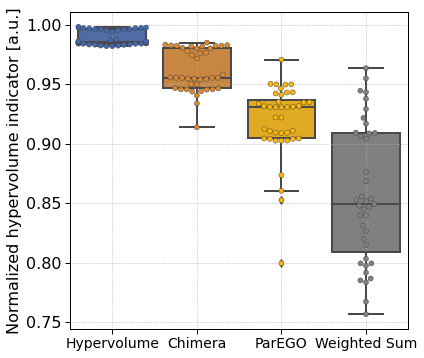

In [204]:
fig, ax = plt.subplots(figsize=(6, 5))

hue_order = ['#4267B2', '#dd882c', '#ffb703', 'gray']
order=['Hypervolume', 'Chimera', 'ParEGO', 'Weighted Sum']
pal = {o:h for o,h in zip(order, hue_order)}
sns.boxplot(data=df_hvol, x='kind', y='hypervol', palette=pal, ax=ax, linewidth=2.0)
sns.swarmplot(data=df_hvol, x='kind', y='hypervol', palette=pal, ax=ax, linewidth=0.5,)
ax.set_ylabel('Normalized hypervolume indicator [a.u.]', fontsize=16)
# ax.set_xlabel('Scalarizing strategy', fontsize=12)
ax.set_xlabel('')
ax.grid(linestyle=":")

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('redoxmers_hypervolume_boxplots.png', dpi=300)

In [48]:
fig = px.scatter_3d(df_hv, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_hv[df_hv['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# fig.update_layout(
#     title="Hypervolume",
#     xaxis_title=r'$\Delta_{abs}$ [nm]',
#     yaxis_title=r'$E^{red}$  [V vs. Li/Li+]',
#     zaxis_title=r'$G^{solv}$ [eV]',
#     #legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
# )

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

fig.write_image("hypervolume_redoxmers_run.png")
fig.show()

In [49]:
fig = px.scatter_3d(df_chi, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_chi[df_chi['type']=='front']
fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()

In [50]:
fig = px.scatter_3d(df_ws, x='abs_lam_diff', y='ered', z='gsol', size='size')

pareto_points = df_ws[df_ws['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()

In [51]:
fig = px.scatter_3d(df_par, x='abs_lam_diff', y='ered', z='gsol', size='size')
pareto_points = df_par[df_par['type']=='front']

fig.add_trace(go.Mesh3d(x=pareto_points['abs_lam_diff'].values,
                   y=pareto_points['ered'].values,
                   z=pareto_points['gsol'].values,
                   opacity=0.2,
                   color='blue'
                  ))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_scenes(xaxis_title_text=r'$\Delta_{abs}$ [nm]',  
                  yaxis_title_text=r'$E^{red}$  [V vs. Li/Li+]',  
                  zaxis_title_text=r'$G^{solv}$ [eV]',
                  )

# axes[0].set_ylabel(r'$\Delta_{`abs}$ [nm]', fontsize=12)
# axes[1].set_ylabel(r'$E^{red}$  [V vs. Li/Li+]', fontsize=12)
# axes[2].set_ylabel(r'$G^{solv}$ [eV]', fontsize=12)

#fig.write_image("chimera_redoxmers_run.png")
fig.show()

In [31]:
from scipy.stats import ttest_ind

In [14]:
raw_df.head()

,Unnamed: 0,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,...,r5_MW,r5_AMW,r5_WPath,r5_WPol,r5_Zagreb1,r5_Zagreb2,r5_mZagreb2,r5_type,r5_ix,product_mols
0,0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,16.031300,3.206260,0,0,0.0,0.0,0.0,R5,0,<rdkit.Chem.rdchem.Mol object at 0x7fd9b6776530>
1,1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,70.003035,14.000607,9,0,12.0,9.0,1.0,R5,1,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5a57300>
2,2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,27.010899,9.003633,1,0,2.0,1.0,1.0,R5,2,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5ac3b20>
3,3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,32.026215,5.337702,1,0,2.0,1.0,1.0,R5,3,<rdkit.Chem.rdchem.Mol object at 0x7fd9b5ac3a80>
4,4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC,CCOC,R3_0,C,C,R4_0,C,...,85.997949,14.332992,16,0,20.0,16.0,1.0,R5,4,<rdkit.Chem.rdchem.Mol object at 0x7fd9b4933c10>


In [15]:
raw_df.columns[:20]

Index(['Unnamed: 0', 'product_smiles', 'r1_label', 'r1_smiles',
       'r1_smiles_raw', 'r3_label', 'r3_smiles', 'r3_smiles_raw', 'r4_label',
       'r4_smiles', 'r4_smiles_raw', 'r5_label', 'r5_smiles', 'r5_smiles_raw',
       'ered', 'gsol', 'abs_lam', 'abs_lam_diff', 'ra_xgb', 'ra_nn'],
      dtype='object')

In [19]:
mean_abs_lam_r11 = raw_df[raw_df['r1_label']=='R1_0']['abs_lam'].mean()
mean_abs_lam_diff_r11 = raw_df[raw_df['r1_label']=='R1_0']['abs_lam_diff'].mean()

mean_abs_lam_r12 = raw_df[raw_df['r1_label']=='R1_1']['abs_lam'].mean()
mean_abs_lam_diff_r12 = raw_df[raw_df['r1_label']=='R1_1']['abs_lam_diff'].mean()

In [21]:
print(mean_abs_lam_r11, mean_abs_lam_r12)
print(mean_abs_lam_diff_r11, mean_abs_lam_diff_r12)

358.95957325746775 355.9003125000003
32.467852062588925 39.342784090909085


In [37]:
def get_average(rgroup, option, df):
    sub_df = df[df[rgroup]==option]
    return {
        'abs_lam': sub_df['abs_lam'].mean(),
        'abs_lam_std': sub_df['abs_lam'].std(),
        'abs_lam_stde': sub_df['abs_lam'].std() / np.sqrt(sub_df.shape[0]),
        'abs_lam_diff': sub_df['abs_lam_diff'].mean(),
        'abs_lam_diff_std': sub_df['abs_lam_diff'].std(),
        'abs_lam_diff_stde': sub_df['abs_lam_diff'].std() / np.sqrt(sub_df.shape[0]),
        'ered': sub_df['ered'].mean(),
        'ered_std': sub_df['ered'].std(),
        'ered_stde': sub_df['ered'].std() / np.sqrt(sub_df.shape[0]),
        'gsol': sub_df['gsol'].mean(),
        'gsol_std': sub_df['gsol'].std(),
        'gsol_stde': sub_df['gsol'].std() / np.sqrt(sub_df.shape[0]),
    }

In [33]:
r11 = get_average('r1_label', 'R1_0', raw_df)
r12 = get_average('r1_label', 'R1_1', raw_df)

print(r11)
print(' ')
print(r12)

r11_gsol = raw_df[raw_df['r1_label']=='R1_0']['gsol'].values
r12_gsol = raw_df[raw_df['r1_label']=='R1_1']['gsol'].values

ttest_ind(r11_gsol, r12_gsol)



{'abs_lam': 358.95957325746775, 'abs_lam_std': 33.70920158247006, 'abs_lam_stde': 1.2713666168476783, 'abs_lam_diff': 32.467852062588925, 'abs_lam_diff_std': 18.39317827125737, 'abs_lam_diff_stde': 0.6937118571199099, 'ered': 2.2478907814935987, 'ered_std': 0.3055366483825762, 'ered_stde': 0.011523532944759553, 'gsol': -0.7580281400142242, 'gsol_std': 0.11812879161680898, 'gsol_stde': 0.004455311757614222}
 
{'abs_lam': 355.9003125000003, 'abs_lam_std': 40.81840431435207, 'abs_lam_stde': 1.538401496042385, 'abs_lam_diff': 39.342784090909085, 'abs_lam_diff_std': 21.940890245932184, 'abs_lam_diff_stde': 0.8269284149105189, 'ered': 2.3909569746022723, 'ered_std': 0.3179446564854157, 'ered_stde': 0.011982990109779108, 'gsol': -0.5706581691477272, 'gsol_std': 0.11747946617753979, 'gsol_stde': 0.004427673975933491}


Ttest_indResult(statistic=-29.83016276056716, pvalue=7.038704376267108e-152)

/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


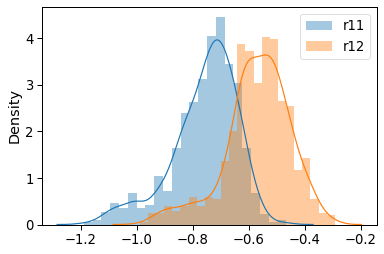

In [34]:
sns.distplot(r11_gsol, label='r11')
sns.distplot(r12_gsol, label='r12')
plt.legend()

In [40]:
r23 = get_average('r3_label', 'R3_2', raw_df)
r28 = get_average('r3_label', 'R3_7', raw_df)

In [42]:
print(r23) 
print('')
print(r28) # chimera hypervolume favoured --> roughly 50% relative requency 10/20 redoxmers

{'abs_lam': 353.82250000000005, 'abs_lam_std': 41.56206690171768, 'abs_lam_stde': 3.132858668741966, 'abs_lam_diff': 41.744659090909096, 'abs_lam_diff_std': 20.636867976587848, 'abs_lam_diff_stde': 1.5555624528736984, 'ered': 2.5838330497727275, 'ered_std': 0.257896558134119, 'ered_stde': 0.0194396845012489, 'gsol': -0.714595358693182, 'gsol_std': 0.14908556136148896, 'gsol_stde': 0.011237747015808305}

{'abs_lam': 400.56392045454555, 'abs_lam_std': 21.825331467931136, 'abs_lam_stde': 1.645146259187823, 'abs_lam_diff': 27.235170454545457, 'abs_lam_diff_std': 19.687569217276806, 'abs_lam_diff_stde': 1.4840063665422298, 'ered': 2.1113318635795455, 'ered_std': 0.2861085058897072, 'ered_stde': 0.021566240076485155, 'gsol': -0.713810752159091, 'gsol_std': 0.14630734195250086, 'gsol_stde': 0.011028330848424295}


In [ ]:
r23 = get_average('r3_label', 'R3_2', raw_df)
r28 = get_average('r3_label', 'R3_7', raw_df)